In [1]:
!nvidia-smi

Wed Sep 16 17:03:46 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install wordcloud

In [ ]:
!pip install tensorflow-gpu

In [ ]:
!pip install gdown
!pip install tensorflow_text

In [5]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
from sklearn.model_selection import train_test_split
import tensorflow_hub as hub
import tensorflow_text
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

%matplotlib inline
%config InlineBackend.figure_format='retina'

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [6]:
register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [7]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

# Exploration

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
df_data=pd.read_parquet('/content/drive/My Drive/Magister/productoDeDatos/proyecto/totaldata_intento2.gzip', engine='pyarrow')

In [10]:
len(df_data)

772858

In [11]:
df_data.groupby(['label'])['label'].agg('count')

label
0    270775
1    426055
2     76028
Name: label, dtype: int64

In [12]:
df_data.head(2)

,text,label
0,"hola, esta plazoleta en los militares llegando...",0
1,"RT Renato, eres seco ??????",0


In [13]:
df_data = df_data[df_data.label < 2]

In [14]:
df_data.groupby(['label'])['label'].agg('count')

label
0    270775
1    426055
Name: label, dtype: int64

In [15]:
df_pos = df_data[df_data['label'] == 0].sample(270775)
df_neg = df_data[df_data['label'] == 1].sample(426055)

In [16]:
review_df = df_pos.append(df_neg, ignore_index=True, sort=False)

In [17]:
review_df.groupby(['label'])['label'].agg('count')

label
0    270775
1    426055
Name: label, dtype: int64

In [18]:
review_df.head(2)

,text,label
0,Nunca me gustó ser la segunda opción fofis :),0
1,"Sr Alcalde, la única calle céntrica que queda ...",0


In [19]:
#review_type
review_df= review_df.rename(columns={"text": "review"})

In [20]:
review_df['review_type']='neutro'
review_df.loc[review_df.label == 0, "review_type"] = 'good'
review_df.loc[review_df.label == 1, "review_type"] = 'bad'

In [21]:
review_df.head(2)

,review,label,review_type
0,Nunca me gustó ser la segunda opción fofis :),0,good
1,"Sr Alcalde, la única calle céntrica que queda ...",0,good


In [22]:
review_df = review_df[['review','review_type']]

In [23]:
review_df.head(1)

,review,review_type
0,Nunca me gustó ser la segunda opción fofis :),good


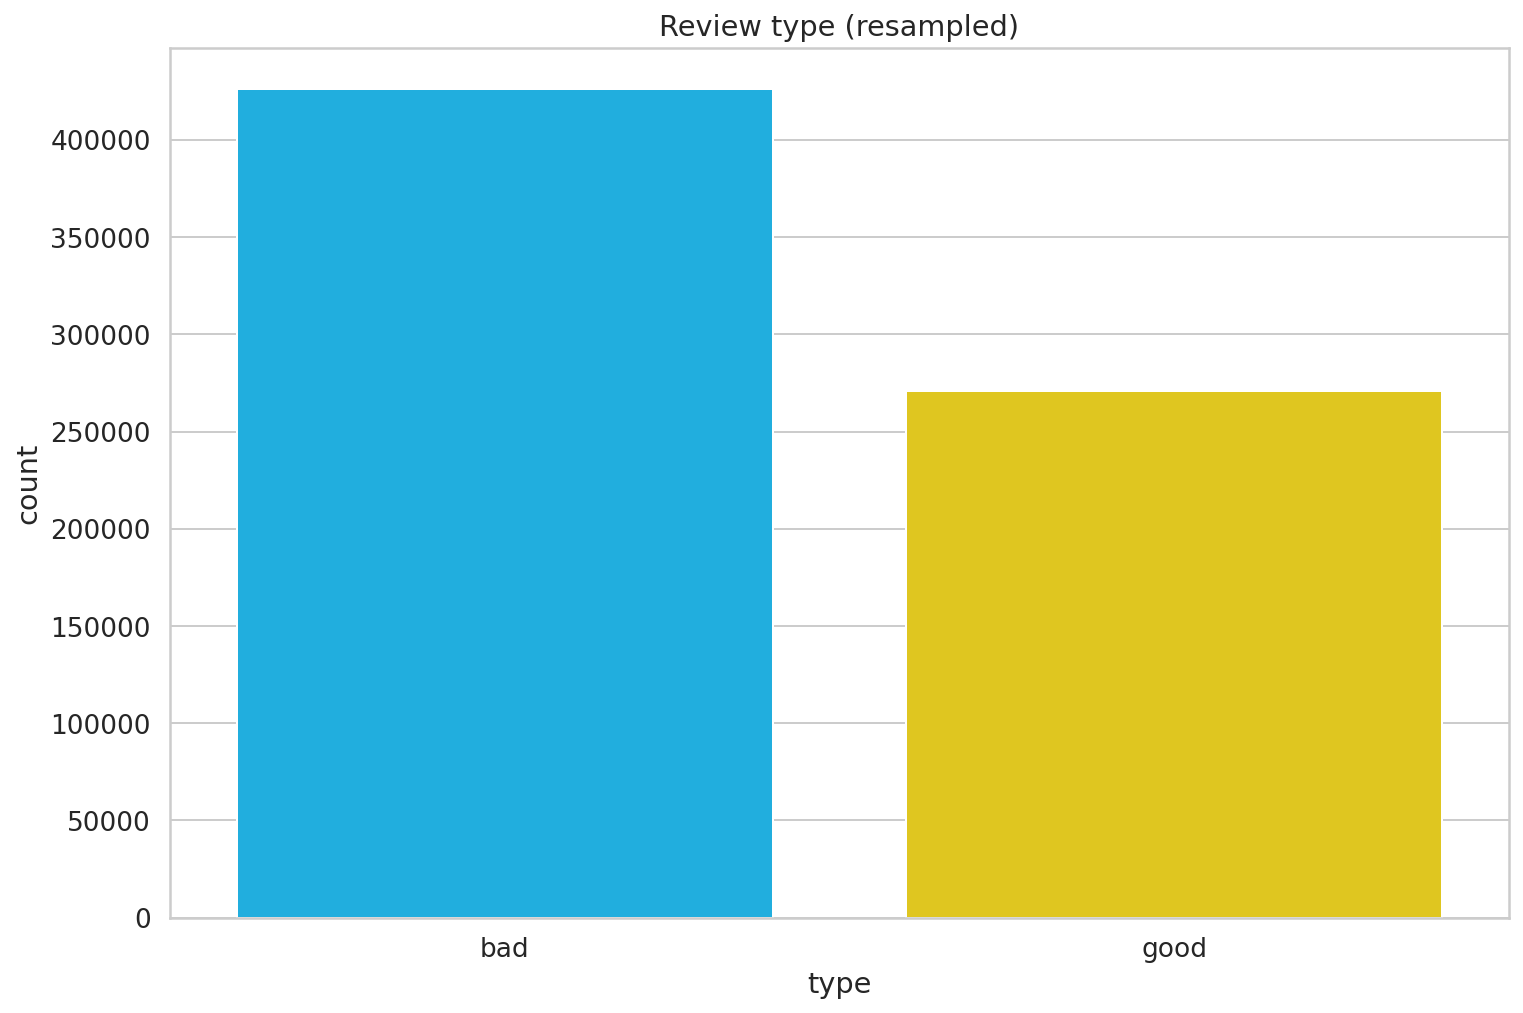

In [24]:
sns.countplot(
  x='review_type',
  data=review_df,
  order=review_df.review_type.value_counts().index
)

plt.xlabel("type")
plt.title("Review type (resampled)");

# Universal Sentence Encoder

In [25]:
use = hub.load("https://tfhub.dev/google/universal-sentence-encoder-multilingual-large/3")

In [26]:
sent_1 = ["the location is great"]
sent_2 = ["amazing location"]

emb_1 = use(sent_1)
emb_2 = use(sent_2)

In [27]:
emb_1.shape

TensorShape([1, 512])

In [28]:
np.inner(emb_1, emb_2).flatten()[0]

0.79254687

# Preprocessing

In [29]:
from sklearn.preprocessing import OneHotEncoder

type_one_hot = OneHotEncoder(sparse=False).fit_transform(
  review_df.review_type.to_numpy().reshape(-1, 1)
)

In [30]:
train_reviews, test_reviews, y_train, y_test =\
  train_test_split(
    review_df.review, 
    type_one_hot, 
    test_size=.1, 
    random_state=RANDOM_SEED
  )

In [31]:
X_train = []
for r in tqdm(train_reviews):
  emb = use(r)
  review_emb = tf.reshape(emb, [-1]).numpy()
  X_train.append(review_emb)

X_train = np.array(X_train)

 91%|█████████ | 570026/627147 [2:15:12<13:18, 71.50it/s]

Buffered data was truncated after reaching the output size limit.

In [32]:
X_test = []
for r in tqdm(test_reviews):
  emb = use(r)
  review_emb = tf.reshape(emb, [-1]).numpy()
  X_test.append(review_emb)

X_test = np.array(X_test)

100%|██████████| 69683/69683 [16:13<00:00, 71.56it/s]


In [33]:
print(X_train.shape, X_test.shape)

(627147, 512) (69683, 512)


In [34]:
print(X_train.shape, y_train.shape)

(627147, 512) (627147, 2)


# Sentiment Analysis

In [35]:
model = keras.Sequential()

model.add(
  keras.layers.Dense(
    units=256,
    input_shape=(X_train.shape[1], ),
    activation='relu'
  )
)
model.add(
  keras.layers.Dropout(rate=0.5)
)

model.add(
  keras.layers.Dense(
    units=128,
    activation='relu'
  )
)
model.add(
  keras.layers.Dropout(rate=0.5)
)

model.add(keras.layers.Dense(2, activation='softmax'))
model.compile(
    loss='categorical_crossentropy', 
    optimizer=keras.optimizers.Adam(0.001),
    metrics=['accuracy']
)

In [36]:
history = model.fit(
    X_train, y_train, 
    epochs=10, 
    batch_size=16, 
    validation_split=0.1, 
    verbose=1, 
    shuffle=True
)

Epoch 1/10
35277/35277 [==============================] - 80s 2ms/step - loss: 0.1504 - accuracy: 0.9418 - val_loss: 0.1158 - val_accuracy: 0.9558
Epoch 2/10
35277/35277 [==============================] - 80s 2ms/step - loss: 0.1235 - accuracy: 0.9533 - val_loss: 0.1064 - val_accuracy: 0.9595
Epoch 3/10
35277/35277 [==============================] - 81s 2ms/step - loss: 0.1144 - accuracy: 0.9569 - val_loss: 0.1017 - val_accuracy: 0.9619
Epoch 4/10
35277/35277 [==============================] - 86s 2ms/step - loss: 0.1084 - accuracy: 0.9597 - val_loss: 0.0997 - val_accuracy: 0.9622
Epoch 5/10
35277/35277 [==============================] - 85s 2ms/step - loss: 0.1046 - accuracy: 0.9611 - val_loss: 0.0978 - val_accuracy: 0.9625
Epoch 6/10
35277/35277 [==============================] - 84s 2ms/step - loss: 0.1015 - accuracy: 0.9622 - val_loss: 0.0984 - val_accuracy: 0.9636
Epoch 7/10
35277/35277 [==============================] - 83s 2ms/step - loss: 0.0989 - accuracy: 0.9632 - val_loss: 0

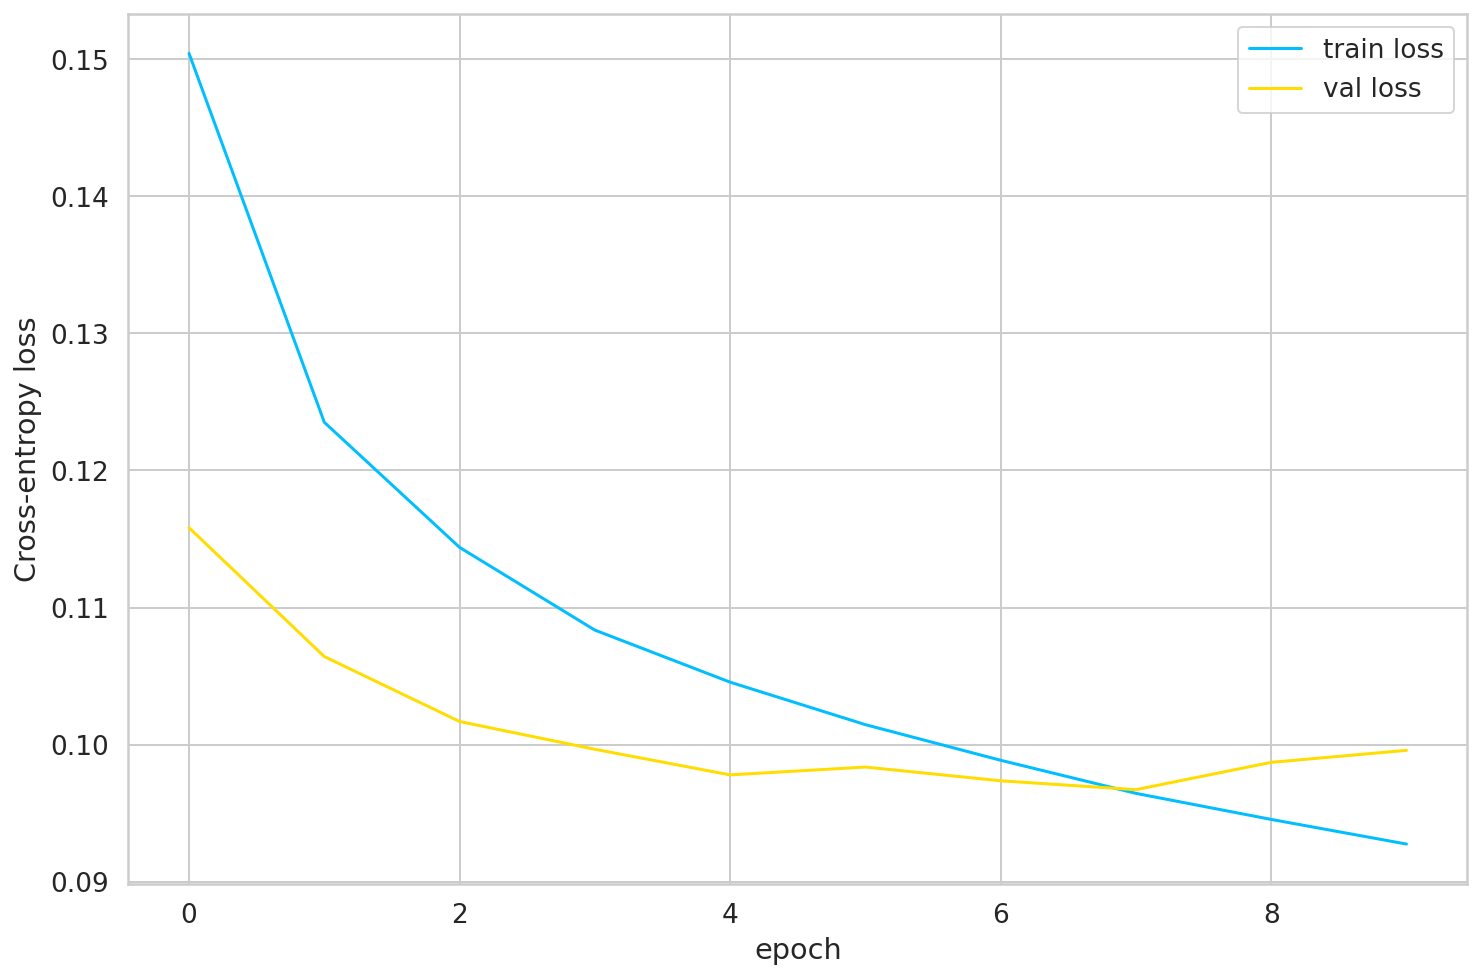

In [37]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel("epoch")
plt.ylabel("Cross-entropy loss")
plt.legend();

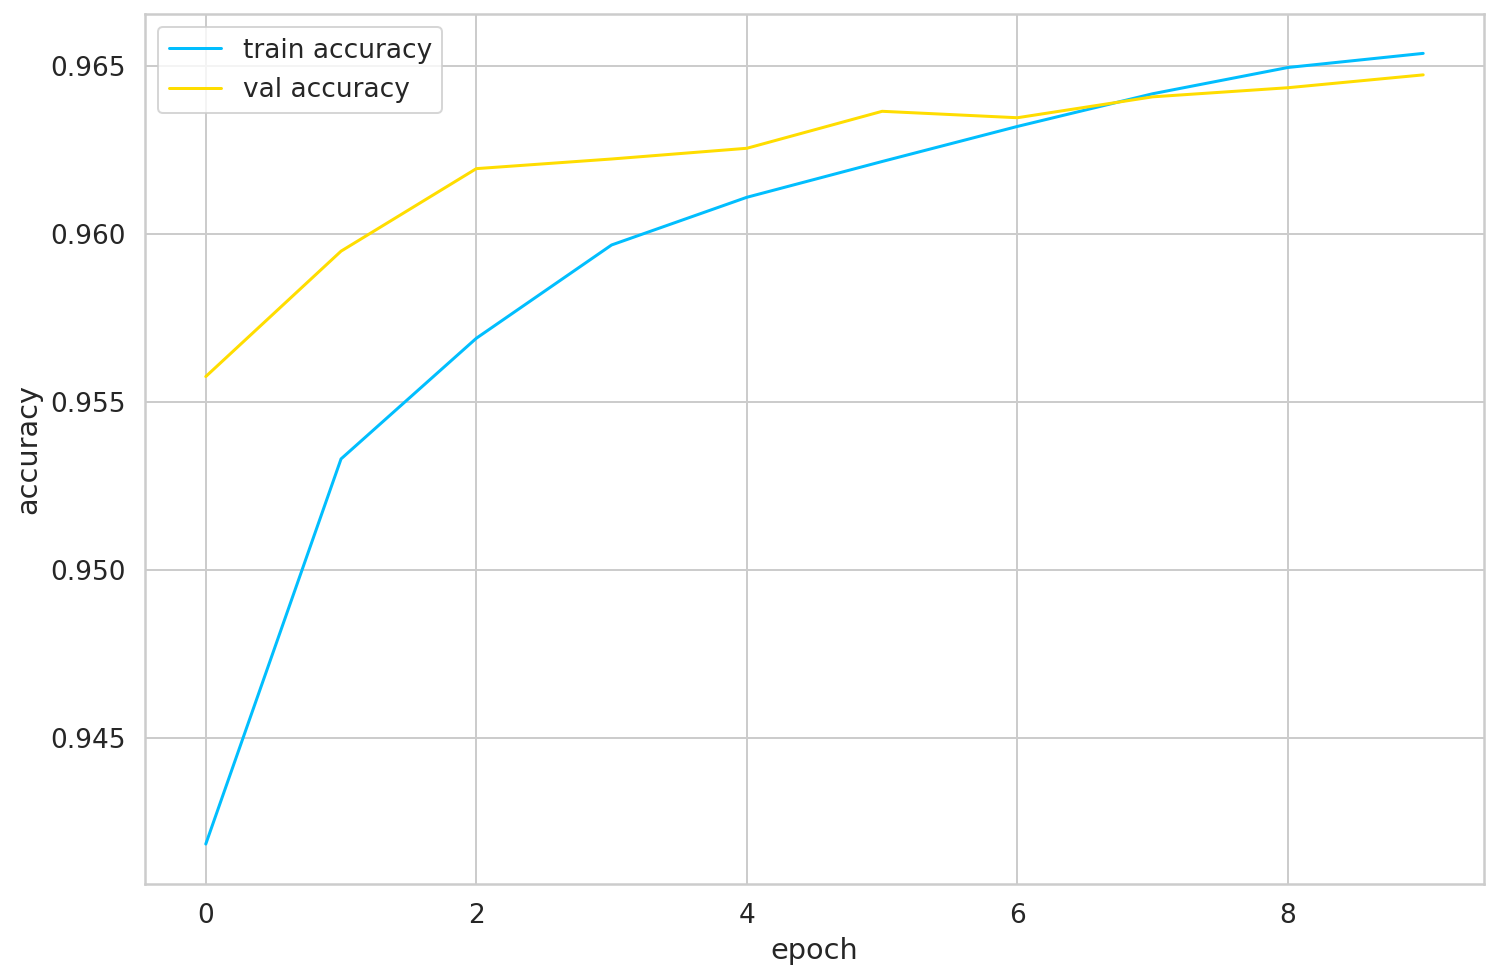

In [38]:
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend();

In [39]:
model.evaluate(X_test, y_test)

2178/2178 [==============================] - 5s 2ms/step - loss: 0.0981 - accuracy: 0.9647


[0.09805606305599213, 0.9647259712219238]

# Predictions

In [40]:
print(test_reviews.iloc[0])
print("Bad" if y_test[0][0] == 1 else "Good")

Tenía tantas ganas de enviarte un mensaje, hablar cntg y contarte cómo van las cosas pero no puedo :(
Bad


In [41]:
y_pred = model.predict(X_test[:1])
print(y_pred)
"Bad" if np.argmax(y_pred) == 0 else "Good"

[[9.9999475e-01 5.2115647e-06]]


'Bad'

In [42]:
print(test_reviews.iloc[1])
print("Bad" if y_test[1][0] == 1 else "Good")

Comparto las ideas del manifiesto de mujeres que lidera Amelia Valcárcel.La igualdad,pilar del socialismo.RbCb http://t.co/ZqoCfbpt
Good


In [43]:
y_pred = model.predict(X_test[1:2])
print(y_pred)
"Bad" if np.argmax(y_pred) == 0 else "Good"

[[2.7579752e-06 9.9999726e-01]]


'Good'

In [44]:
print(test_reviews.iloc[5])
print("Bad" if y_test[5][0] == 1 else "Good")

Utilizo algunas excusas alsdjhj Estoy avergonzado :(
Bad


In [45]:
y_pred = model.predict(X_test[5:6])
print(y_pred)
"Bad" if np.argmax(y_pred) == 0 else "Good"

[[0.9952296  0.00477039]]


'Bad'

In [58]:
X_test[5:6].shape

(1, 512)

In [46]:
model.save('/content/drive/My Drive/Magister/productoDeDatos/proyecto/secuencial_model.h5')